# comparison with weather stations

compare the date of maximum SWE to MODIS derived snow appearance / disappearance

In [1]:
import adlfs
import xarray as xr
import pathlib
import zarr
import rioxarray as rxr
import pandas as pd
import geopandas as gpd
import easysnowdata
import numpy as np
import matplotlib.pyplot as plt
import coiled
import rasterio

In [2]:
sas_token = pathlib.Path("sas_token.txt").read_text()

mask_store = adlfs.AzureBlobFileSystem(
    account_name="snowmelt", credential=sas_token
).get_mapper("snowmelt/snow_cover/global_modis_snow_cover.zarr")

test_modis_snow_cover_vs_snotel_store = adlfs.AzureBlobFileSystem(
    account_name="snowmelt", credential=sas_token
).get_mapper("snowmelt/snow_cover/test_modis_snow_cover_vs_snotel.zarr")

## load in snow cover data

In [3]:
seasonal_snow_mask_ds = xr.open_zarr(mask_store,
                                     decode_coords='all',
                                     consolidated=True,
                                     mask_and_scale=True,
                                     )
seasonal_snow_mask_ds

<xarray.Dataset> Size: 448GB
Dimensions:               (water_year: 10, y: 43200, x: 86400)
Coordinates:
    spatial_ref           int64 8B ...
  * water_year            (water_year) int64 80B 2015 2016 2017 ... 2023 2024
  * x                     (x) float64 691kB -2.001e+07 -2.001e+07 ... 2.001e+07
  * y                     (y) float64 346kB 1.001e+07 1.001e+07 ... -1.001e+07
Data variables:
    SAD_DOWY              (water_year, y, x) float32 149GB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
    SDD_DOWY              (water_year, y, x) float32 149GB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
    max_consec_snow_days  (water_year, y, x) float32 149GB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
Attributes:
    processed_tiles:  ['h18_v17', 'h15_v16', 'h19_v17', 'h18_v16', 'h17_v17',...

## processing

In [11]:
StationsWUS = easysnowdata.automatic_weather_stations.StationCollection()
StationsWUS.get_entire_data_archive()

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Decompressing data...
Creating xarray.Dataset from the uncompressed data...
Done! Entire archive dataset has been added to the station object. Please use the .entire_data_archive attribute to access.


In [12]:
stations_WUS_da = StationsWUS.entire_data_archive['WTEQ'].sel(time=slice('2014-10-01','2024-09-30'))
stations_WUS_da

<xarray.DataArray 'WTEQ' (station: 969, time: 3653)> Size: 28MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(969, 3653))
Coordinates: (12/17)
  * time           (time) datetime64[ns] 29kB 2014-10-01 ... 2024-09-30
  * station        (station) <U12 47kB '1135_UT_SNTL' ... '915_ID_SNTL'
    name           (station) <U24 93kB 'Burts Miller Ranch' ... 'Schwartz Lake'
    network        (station) <U6 23kB 'SNOTEL' 'SNOTEL' ... 'SNOTEL' 'SNOTEL'
    elevation_m    (station) float64 8kB 2.438e+03 2.377e+03 ... 2.63e+03
    latitude       (station) float64 8kB 40.98 44.79 37.16 ... 40.28 42.3 44.85
    ...             ...
    beginDate      (station) datetime64[ns] 8kB 2009-10-01 ... 1995-09-26
    endDate        (station) datetime64[ns] 8kB 2025-06-16 ... 2025-06-16
    csvData        (station) bool 969B True True True True ... True True True
    geometry       (station) object 8kB POINT (-110.85075378417969 40.9849205...
    WY             (time) int64 29kB 2015 2015 2015 2015 ... 2024 2024 2024 2024
    DOWY           (time) int64 29kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366

In [13]:
stations_WUS_da = stations_WUS_da.where(stations_WUS_da>=0)

abs_diffs = np.abs(stations_WUS_da.diff(dim='time'))
abs_diffs_forward = abs_diffs.shift(time=1)
abs_diffs_backward = abs_diffs.shift(time=-1)
jump_mask = (abs_diffs_forward < 0.2) & (abs_diffs_backward < 0.2)
stations_WUS_da = stations_WUS_da.where(jump_mask)

window=10
valid_mask = ~np.isnan(stations_WUS_da)
rolling_valid = valid_mask.rolling(time=window*2, center=True).sum()
stations_WUS_da = stations_WUS_da.where(rolling_valid >= window)  


def check_missing_data(group):
    nov_to_apr_mask = group.time.dt.month.isin([11, 12, 1, 2, 3]) # not good!!!!! 
    filtered_group = group.where(nov_to_apr_mask,drop=True)
    missing_data_counts = filtered_group.isnull().sum(dim='time')

    missing_data = missing_data_counts > 30

    valid_data = ~np.isnan(group)

    def calc_location_gaps(location_data):
        valid_indices = ~np.isnan(location_data)
        if not np.any(valid_indices):
            return True
        valid_times = group.time.values[valid_indices]
        gaps = np.diff(valid_times)
        return np.any(gaps / np.timedelta64(1, 'D') > 10)
    
    large_gaps = xr.apply_ufunc(
        calc_location_gaps,
        group,
        input_core_dims=[['time']],
        vectorize=True,
        output_dtypes=[bool]
    )
    

    # Check for proper seasonal evolution
    if valid_data.any():
        first_valid_idx = valid_data.argmax(dim='time')
        last_valid_idx = valid_data[:, ::-1].argmax(dim='time')
        first_valid = group.isel(time=first_valid_idx)
        last_valid = group.isel(time=group.sizes['time'] - last_valid_idx - 1)
        improper_evolution = (first_valid > 0.1) | (last_valid > 0.1)
    else:
        improper_evolution = True

    # print(f'missing data count: {missing_data.sum().values}')
    # print(f'large gaps count: {large_gaps.sum().values}')
    # print(f'improper evolution count: {improper_evolution.sum().values}')

    columns_to_nan = missing_data | large_gaps | improper_evolution
    group[columns_to_nan] = np.nan
    return group

def check_seasonal_snow_swe(group):
    # Count days with SWE >= 0.05 in each window
    sufficient_swe = (group >= 0.05).rolling(time=60, center=True, min_periods=55).sum() #0.01 CHANGED TO 0.2, 20 CM!!!!!!!!!!!
    # Find locations that meet the criteria in any window
    columns_to_keep = (sufficient_swe >= 55).any(dim='time')
    # Mask out columns that don't meet criteria
    columns_to_nan = ~columns_to_keep
    group[columns_to_nan] = np.nan
    return group

def find_pct_max_timing(da, pct, dim='time', skipna=True):
    """Find the time when SWE last crosses below a percentage of max SWE"""
    max_val = da.max(dim=dim, skipna=skipna)
    threshold = max_val * pct
    # Create boolean mask of values above threshold
    above_thresh = xr.where(da >= threshold, 1, np.nan)
    # Find the last True value
    #return above_thresh.sel(time=slice(None, None, -1)).swap_dims({'time':'DOWY'}).idxmax(dim="DOWY", skipna=True).drop_vars('WY').where(lambda x: x>0) #reversed to get last max value instead of first
    return above_thresh.sel(time=slice(None, None, -1)).swap_dims({'time':'DOWY'}).idxmax(dim="DOWY", skipna=True).where(lambda x: x>0) #reversed to get last max value instead of first


stations_WUS_da = stations_WUS_da.groupby('WY').apply(check_missing_data)
stations_WUS_da = stations_WUS_da.groupby('WY').apply(check_seasonal_snow_swe)


#stations_WUS_max_SWE_timing_da = stations_WUS_da.fillna(-9999).groupby("WY").map(lambda x: x.sel(time=slice(None, None, -1)).idxmax("time",skipna=True).DOWY.drop_vars('WY')).where(lambda x: x>0) #reversed to get last max value instead of first
#stations_WUS_max_SWE_timing_da = stations_WUS_da.groupby("WY").map(lambda x: x.sel(time=slice(None, None, -1)).swap_dims({'time':'DOWY'}).idxmax("DOWY",skipna=True).drop_vars('WY')).where(lambda x: x>0)
stations_WUS_max_SWE_timing_da = stations_WUS_da.groupby("WY").map(lambda x: x.sel(time=slice(None, None, -1)).swap_dims({'time':'DOWY'}).idxmax("DOWY",skipna=True)).where(lambda x: x>0)

snow_cover_and_max_swe_timing_WUS_ds = stations_WUS_max_SWE_timing_da.to_dataset(name='station_max_SWE_timing')

snow_cover_and_max_swe_timing_WUS_ds["station_max_SWE_value"] = stations_WUS_da.groupby("WY").max()

pct_list = [0.99, 0.95, 0.9, 0.5]
for pct in pct_list:
    pct_str = str(int(pct * 100))
    snow_cover_and_max_swe_timing_WUS_ds[f'station_max_SWE_{pct_str}pct_timing'] = stations_WUS_da.groupby("WY").map(lambda x: find_pct_max_timing(x, pct)).where(lambda x: x>0)

snow_cover_and_max_swe_timing_WUS_ds

<xarray.Dataset> Size: 796kB
Dimensions:                       (station: 969, WY: 10)
Coordinates: (12/15)
  * station                       (station) <U12 47kB '1135_UT_SNTL' ... '915...
    name                          (station) <U24 93kB 'Burts Miller Ranch' .....
    network                       (station) <U6 23kB 'SNOTEL' ... 'SNOTEL'
    elevation_m                   (station) float64 8kB 2.438e+03 ... 2.63e+03
    latitude                      (station) float64 8kB 40.98 44.79 ... 44.85
    longitude                     (station) float64 8kB -110.9 -112.1 ... -113.8
    ...                            ...
    mountainRange                 (station) object 8kB None ... 'Idaho-Bitter...
    beginDate                     (station) datetime64[ns] 8kB 2009-10-01 ......
    endDate                       (station) datetime64[ns] 8kB 2025-06-16 ......
    csvData                       (station) bool 969B True True ... True True
    geometry                      (station) object 8kB POINT (-110.8507537841...
  * WY                            (WY) int64 80B 2015 2016 2017 ... 2023 2024
Data variables:
    station_max_SWE_timing        (station, WY) float64 78kB 165.0 ... 193.0
    station_max_SWE_value         (station, WY) float64 78kB 0.1168 ... 0.2769
    station_max_SWE_99pct_timing  (station, WY) float64 78kB 165.0 ... 194.0
    station_max_SWE_95pct_timing  (station, WY) float64 78kB 165.0 ... 196.0
    station_max_SWE_90pct_timing  (station, WY) float64 78kB 166.0 ... 197.0
    station_max_SWE_50pct_timing  (station, WY) float64 78kB 170.0 ... 226.0

In [14]:
# snow_cover_and_max_swe_timing_WUS_ds['station_max_SWE_timing'].count(dim='station').plot()

In [15]:
all_stations_gdf = gpd.read_file('~/repos/updated_snotel_locations/snotel_stations_with_updated_locations.geojson').set_index('code')
all_stations_gdf

,name,network,elevation_m,latitude,longitude,state,HUC,mgrs,mountainRange,beginDate,endDate,csvData,coords_source,geometry
code,,,,,,,,,,,,,,
301_CA_SNTL,Adin Mtn,SNOTEL,1886.712036,41.235828,-120.791924,California,180200021403,10TFL,Great Basin Ranges,1983-10-01,2025-03-16,True,original,POINT (-120.79192 41.23583)
907_UT_SNTL,Agua Canyon,SNOTEL,2712.719971,37.522171,-112.271179,Utah,160300020301,12SUG,Colorado Plateau,1994-10-01,2025-03-16,True,updated_from_ally,POINT (-112.27138 37.5223)
916_MT_SNTL,Albro Lake,SNOTEL,2529.840088,45.597229,-111.959023,Montana,100200050701,12TVR,Central Montana Rocky Mountains,1996-09-01,2025-03-16,True,original,POINT (-111.95902 45.59723)
1267_AK_SNTL,Alexander Lake,SNOTEL,48.768002,61.749668,-150.889664,Alaska,190205051106,05VPJ,None,2014-08-28,2025-03-16,True,original,POINT (-150.88966 61.74967)
908_WA_SNTL,Alpine Meadows,SNOTEL,1066.800049,47.779572,-121.698471,Washington,171100100501,10TET,Cascade Range,1994-09-01,2025-03-16,True,original,POINT (-121.69847 47.77957)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SLT,Slate Creek,CCSS,1737.360000,41.043980,-122.480103,California,180200050304,10TEL,Klamath Mountains,2004-10-01,2025-03-16,True,original,POINT (-122.4801 41.04398)
SLI,Slide Canyon,CCSS,2804.160000,38.091234,-119.431881,California,180400090501,11SKC,Sierra Nevada,2005-10-01,2025-03-16,True,original,POINT (-119.43188 38.09123)
SLK,South Lake,CCSS,2926.080000,37.175903,-118.562660,California,180901020601,11SLB,Sierra Nevada,2004-10-01,2025-03-16,True,original,POINT (-118.56266 37.1759)


In [ ]:
def get_station_gdf(station_code, all_stations_gdf, buffer_radius=None):
    station_gdf = all_stations_gdf[all_stations_gdf.index==station_code]
    station_epsg = station_gdf.estimate_utm_crs().to_epsg()
    station_gdf = station_gdf.to_crs(epsg=station_epsg)

    if buffer_radius:
        station_gdf['geometry'] = station_gdf.geometry.buffer(buffer_radius)

    station_gdf['clipbox_window'] = station_gdf.geometry.buffer(3000)

    return station_gdf

def get_station_snow_cover_data(station_gdf, seasonal_snow_mask_ds, resampling=rasterio.enums.Resampling.bilinear):
    # accept the station_gdf, use rio.clip_box on the seasonal_snow_mask_ds, then reproject the data to the station's CRS
    clipbox_gdf = station_gdf.copy()
    if 'clipbox_window' in station_gdf.columns:
        clipbox_gdf['geometry'] = station_gdf['clipbox_window']

    station_snow_cover_ds = seasonal_snow_mask_ds.rio.clip_box(
        *clipbox_gdf.to_crs(seasonal_snow_mask_ds.rio.crs).total_bounds
    ).rio.reproject(station_gdf.crs, resolution=80, resampling=resampling)

    fcf_da = easysnowdata.remote_sensing.get_forest_cover_fraction(station_snow_cover_ds.rio.transform_bounds('EPSG:4326'),mask_nodata=True).rio.reproject_match(station_snow_cover_ds,resampling=rasterio.enums.Resampling.bilinear)
    station_snow_cover_ds['fcf'] = fcf_da

    dem_da = easysnowdata.topography.get_copernicus_dem(station_snow_cover_ds.rio.transform_bounds('EPSG:4326'), resolution=30).rio.reproject_match(station_snow_cover_ds,resampling=rasterio.enums.Resampling.bilinear)
    station_snow_cover_ds['dem'] = dem_da

    esa_da = easysnowdata.remote_sensing.get_esa_worldcover(station_snow_cover_ds.rio.transform_bounds('EPSG:4326'),mask_nodata=True).rio.reproject_match(station_snow_cover_ds,resampling=rasterio.enums.Resampling.mode)
    station_snow_cover_ds['worldcover'] = esa_da

    station_snow_cover_ds = station_snow_cover_ds.rio.clip(
        station_gdf.geometry,
        crs=station_gdf.crs,
        drop=True,
    )


    return station_snow_cover_ds

In [ ]:
test_station_code = 'LVT'
test_station_gdf = get_station_gdf(test_station_code, all_stations_gdf, buffer_radius=1000)
test_station_gdf

In [ ]:
station_snow_cover_ds = get_station_snow_cover_data(test_station_gdf, 
                                                    seasonal_snow_mask_ds,
                                                    resampling=rasterio.enums.Resampling.bilinear)
station_snow_cover_ds

In [ ]:
# station_snow_cover_ds['SAD_DOWY'].plot.imshow(col='water_year',col_wrap=5)
# station_snow_cover_ds['SDD_DOWY'].plot.imshow(col='water_year',col_wrap=5)
# station_snow_cover_ds['max_consec_snow_days'].plot.imshow(col='water_year',col_wrap=5)

In [ ]:
# now take runoff_onset_max_swe_timing_WUS_ds and add a buffer dimension, with coordinates 0, 100, 300, 500, 1000
buffer_radii = [0, 100, 300, 500, 1000]  # in meters

def process_station_snow_cover(station_code):

    results = []
    max_buffer_radius = max(buffer_radii)
    station_max_buffer_gdf = get_station_gdf(station_code, all_stations_gdf, buffer_radius=max_buffer_radius)
    station_snow_cover_max_buffer_ds = get_station_snow_cover_data(station_max_buffer_gdf, seasonal_snow_mask_ds).compute().rename({'water_year':'WY'})

    for buffer_radius in buffer_radii:
        station_gdf = get_station_gdf(station_code, all_stations_gdf, buffer_radius=buffer_radius)
        station_snow_cover_ds = station_snow_cover_max_buffer_ds.rio.clip(station_gdf.geometry)

        station_snow_cover_ds = station_snow_cover_ds.where((station_snow_cover_ds['worldcover']!=80) & (station_snow_cover_ds['worldcover']!=50))

        result = {
            'station': station_code,
            'buffer_radius': buffer_radius,
            'SAD_DOWY': station_snow_cover_ds['SAD_DOWY'].median(dim=['x','y']),
            'SDD_DOWY': station_snow_cover_ds['SDD_DOWY'].median(dim=['x','y']),
            'max_consec_snow_days': station_snow_cover_ds['max_consec_snow_days'].median(dim=['x','y']),
            'fcf': station_snow_cover_ds['fcf'].median(dim=['x','y']),
        }

        results.append(result)

    return results



In [ ]:
# results = process_station_snow_cover(test_station_code)
# results

In [ ]:
cluster = coiled.Cluster(idle_timeout="10 minutes",
                         n_workers=30,
                         #n_workers=8,
                         #n_workers=10,
                         worker_memory="8 GB", #coiled.list_instance_types(backend="azure")
                         worker_cpu=4,
                         #worker_options={"nthreads": 1},
                         #worker_options={"nthreads": 32},# 16 8 4 oversubscribe?
                         #scheduler_memory="128 GB",
                         #scheduler_memory="16 GB",
                         spot_policy="spot", # spot usually
                         #software="sar_snowmelt_timing",
                         environ={"GDAL_DISABLE_READDIR_ON_OPEN": "EMPTY_DIR"},
                         #container="mcr.microsoft.com/planetary-computer/python:latest",
                         workspace="uwtacolab",
                         
                         )

client = cluster.get_client()

In [ ]:
client.restart()

In [ ]:
futures = [client.submit(process_station_snow_cover, station_code, retries=100) for station_code in snow_cover_and_max_swe_timing_WUS_ds.station.values]
futures

In [ ]:
stati = [future.status for future in futures]
np.unique(stati,return_counts=True)

In [ ]:
station_results = client.gather(futures)
station_results

In [ ]:
snow_cover_and_max_swe_timing_WUS_ds

In [ ]:
empty_SDD_DOWY_da = xr.DataArray(
    np.nan,
    dims=['station', 'WY','buffer_radius'],
    coords={
        'station': snow_cover_and_max_swe_timing_WUS_ds.station.values,
        'WY': snow_cover_and_max_swe_timing_WUS_ds.WY.values,
        'buffer_radius': buffer_radii
    },
    name='SDD_DOWY'
)

empty_SAD_DOWY_da = xr.DataArray(
    np.nan,
    dims=['station', 'WY','buffer_radius'],
    coords={
        'station': snow_cover_and_max_swe_timing_WUS_ds.station.values,
        'WY': snow_cover_and_max_swe_timing_WUS_ds.WY.values,
        'buffer_radius': buffer_radii
    },
    name='SAD_DOWY'
)
empty_max_consec_snow_days_da = xr.DataArray(
    np.nan,
    dims=['station', 'WY','buffer_radius'],
    coords={
        'station': snow_cover_and_max_swe_timing_WUS_ds.station.values,
        'WY': snow_cover_and_max_swe_timing_WUS_ds.WY.values,
        'buffer_radius': buffer_radii
    },
    name='max_consec_snow_days'
)
empty_fcf_da = xr.DataArray(
    np.nan,
    dims=['station', 'WY','buffer_radius'],
    coords={
        'station': snow_cover_and_max_swe_timing_WUS_ds.station.values,
        'WY': snow_cover_and_max_swe_timing_WUS_ds.WY.values,
        'buffer_radius': buffer_radii
    },
    name='fcf'
)

In [ ]:
# for each station, for each buffer radius (create a new dimension in runoff_onset_max_swe_timing_WUS_ds), add the snow cover data (variables SAD_DOWY, SDD_DOWY, max_consec_snow_days, fcf) and add it to the runoff_onset_max_swe_timing_WUS_ds
for station_result in station_results:
    station_code = station_result[0]['station']
    for result in station_result:
        buffer_radius = result['buffer_radius']
        
        empty_SAD_DOWY_da.loc[dict(station=station_code, buffer_radius=buffer_radius)] = result['SAD_DOWY']
        empty_SDD_DOWY_da.loc[dict(station=station_code, buffer_radius=buffer_radius)] = result['SDD_DOWY']
        empty_max_consec_snow_days_da.loc[dict(station=station_code, buffer_radius=buffer_radius)] = result['max_consec_snow_days']
        empty_fcf_da.loc[dict(station=station_code, buffer_radius=buffer_radius)] = result['fcf']

In [ ]:
modis_snow_cover_vs_snotel_max_swe_timing_ds = snow_cover_and_max_swe_timing_WUS_ds.assign(
    SAD_DOWY=empty_SAD_DOWY_da,
    SDD_DOWY=empty_SDD_DOWY_da,
    max_consec_snow_days=empty_max_consec_snow_days_da,
    fcf=empty_fcf_da
)
modis_snow_cover_vs_snotel_max_swe_timing_ds


In [ ]:
modis_snow_cover_vs_snotel_max_swe_timing_ds.drop_vars(['geometry','mountainRange']).to_zarr(test_modis_snow_cover_vs_snotel_store, mode='w', consolidated=True, compute=True)

## open comparison dataset

In [4]:
modis_snow_cover_vs_snotel_max_swe_timing_ds = xr.open_zarr(test_modis_snow_cover_vs_snotel_store, consolidated=True, mask_and_scale=True)
modis_snow_cover_vs_snotel_max_swe_timing_ds

<xarray.Dataset> Size: 2MB
Dimensions:                       (station: 969, WY: 10, buffer_radius: 5)
Coordinates: (12/14)
    HUC                           (station) <U12 47kB dask.array<chunksize=(969,), meta=np.ndarray>
  * WY                            (WY) int64 80B 2015 2016 2017 ... 2023 2024
    beginDate                     (station) datetime64[ns] 8kB dask.array<chunksize=(969,), meta=np.ndarray>
  * buffer_radius                 (buffer_radius) int64 40B 0 100 300 500 1000
    csvData                       (station) bool 969B dask.array<chunksize=(969,), meta=np.ndarray>
    elevation_m                   (station) float64 8kB dask.array<chunksize=(969,), meta=np.ndarray>
    ...                            ...
    longitude                     (station) float64 8kB dask.array<chunksize=(969,), meta=np.ndarray>
    mgrs                          (station) <U5 19kB dask.array<chunksize=(969,), meta=np.ndarray>
    name                          (station) <U24 93kB dask.array<chunksize=(969,), meta=np.ndarray>
    network                       (station) <U6 23kB dask.array<chunksize=(969,), meta=np.ndarray>
    state                         (station) <U12 47kB dask.array<chunksize=(969,), meta=np.ndarray>
  * station                       (station) <U12 47kB '1135_UT_SNTL' ... '915...
Data variables:
    SAD_DOWY                      (station, WY, buffer_radius) float64 388kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>
    SDD_DOWY                      (station, WY, buffer_radius) float64 388kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>
    fcf                           (station, WY, buffer_radius) float64 388kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>
    max_consec_snow_days          (station, WY, buffer_radius) float64 388kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>
    station_max_SWE_50pct_timing  (station, WY) float64 78kB dask.array<chunksize=(969, 10), meta=np.ndarray>
    station_max_SWE_90pct_timing  (station, WY) float64 78kB dask.array<chunksize=(969, 10), meta=np.ndarray>
    station_max_SWE_95pct_timing  (station, WY) float64 78kB dask.array<chunksize=(969, 10), meta=np.ndarray>
    station_max_SWE_99pct_timing  (station, WY) float64 78kB dask.array<chunksize=(969, 10), meta=np.ndarray>
    station_max_SWE_timing        (station, WY) float64 78kB dask.array<chunksize=(969, 10), meta=np.ndarray>
    station_max_SWE_value         (station, WY) float64 78kB dask.array<chunksize=(969, 10), meta=np.ndarray>

In [5]:
modis_snow_cover_vs_snotel_max_swe_timing_ds['max_between_SAD_SDD'] = (
    (modis_snow_cover_vs_snotel_max_swe_timing_ds['station_max_SWE_timing'] >= modis_snow_cover_vs_snotel_max_swe_timing_ds['SAD_DOWY']) &
    (modis_snow_cover_vs_snotel_max_swe_timing_ds['station_max_SWE_timing'] <= modis_snow_cover_vs_snotel_max_swe_timing_ds['SDD_DOWY'])
)

modis_snow_cover_vs_snotel_max_swe_timing_ds['99max_between_SDD_DOWY'] = (
    (modis_snow_cover_vs_snotel_max_swe_timing_ds['station_max_SWE_99pct_timing'] >= modis_snow_cover_vs_snotel_max_swe_timing_ds['SAD_DOWY']) &
    (modis_snow_cover_vs_snotel_max_swe_timing_ds['station_max_SWE_99pct_timing'] <= modis_snow_cover_vs_snotel_max_swe_timing_ds['SDD_DOWY'])
)

modis_snow_cover_vs_snotel_max_swe_timing_ds['95max_between_SDD_DOWY'] = (
    (modis_snow_cover_vs_snotel_max_swe_timing_ds['station_max_SWE_95pct_timing'] >= modis_snow_cover_vs_snotel_max_swe_timing_ds['SAD_DOWY']) &
    (modis_snow_cover_vs_snotel_max_swe_timing_ds['station_max_SWE_95pct_timing'] <= modis_snow_cover_vs_snotel_max_swe_timing_ds['SDD_DOWY'])
)

modis_snow_cover_vs_snotel_max_swe_timing_ds['90max_between_SDD_DOWY'] = (
    (modis_snow_cover_vs_snotel_max_swe_timing_ds['station_max_SWE_90pct_timing'] >= modis_snow_cover_vs_snotel_max_swe_timing_ds['SAD_DOWY']) &
    (modis_snow_cover_vs_snotel_max_swe_timing_ds['station_max_SWE_90pct_timing'] <= modis_snow_cover_vs_snotel_max_swe_timing_ds['SDD_DOWY'])
)

modis_snow_cover_vs_snotel_max_swe_timing_ds['50max_between_SDD_DOWY'] = (
    (modis_snow_cover_vs_snotel_max_swe_timing_ds['station_max_SWE_50pct_timing'] >= modis_snow_cover_vs_snotel_max_swe_timing_ds['SAD_DOWY']) &
    (modis_snow_cover_vs_snotel_max_swe_timing_ds['station_max_SWE_50pct_timing'] <= modis_snow_cover_vs_snotel_max_swe_timing_ds['SDD_DOWY'])
)


modis_snow_cover_vs_snotel_max_swe_timing_ds

<xarray.Dataset> Size: 3MB
Dimensions:                       (station: 969, WY: 10, buffer_radius: 5)
Coordinates: (12/14)
    HUC                           (station) <U12 47kB dask.array<chunksize=(969,), meta=np.ndarray>
  * WY                            (WY) int64 80B 2015 2016 2017 ... 2023 2024
    beginDate                     (station) datetime64[ns] 8kB dask.array<chunksize=(969,), meta=np.ndarray>
  * buffer_radius                 (buffer_radius) int64 40B 0 100 300 500 1000
    csvData                       (station) bool 969B dask.array<chunksize=(969,), meta=np.ndarray>
    elevation_m                   (station) float64 8kB dask.array<chunksize=(969,), meta=np.ndarray>
    ...                            ...
    longitude                     (station) float64 8kB dask.array<chunksize=(969,), meta=np.ndarray>
    mgrs                          (station) <U5 19kB dask.array<chunksize=(969,), meta=np.ndarray>
    name                          (station) <U24 93kB dask.array<chunksize=(969,), meta=np.ndarray>
    network                       (station) <U6 23kB dask.array<chunksize=(969,), meta=np.ndarray>
    state                         (station) <U12 47kB dask.array<chunksize=(969,), meta=np.ndarray>
  * station                       (station) <U12 47kB '1135_UT_SNTL' ... '915...
Data variables: (12/15)
    SAD_DOWY                      (station, WY, buffer_radius) float64 388kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>
    SDD_DOWY                      (station, WY, buffer_radius) float64 388kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>
    fcf                           (station, WY, buffer_radius) float64 388kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>
    max_consec_snow_days          (station, WY, buffer_radius) float64 388kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>
    station_max_SWE_50pct_timing  (station, WY) float64 78kB dask.array<chunksize=(969, 10), meta=np.ndarray>
    station_max_SWE_90pct_timing  (station, WY) float64 78kB dask.array<chunksize=(969, 10), meta=np.ndarray>
    ...                            ...
    station_max_SWE_value         (station, WY) float64 78kB dask.array<chunksize=(969, 10), meta=np.ndarray>
    max_between_SAD_SDD           (station, WY, buffer_radius) bool 48kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>
    99max_between_SDD_DOWY        (station, WY, buffer_radius) bool 48kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>
    95max_between_SDD_DOWY        (station, WY, buffer_radius) bool 48kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>
    90max_between_SDD_DOWY        (station, WY, buffer_radius) bool 48kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>
    50max_between_SDD_DOWY        (station, WY, buffer_radius) bool 48kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>

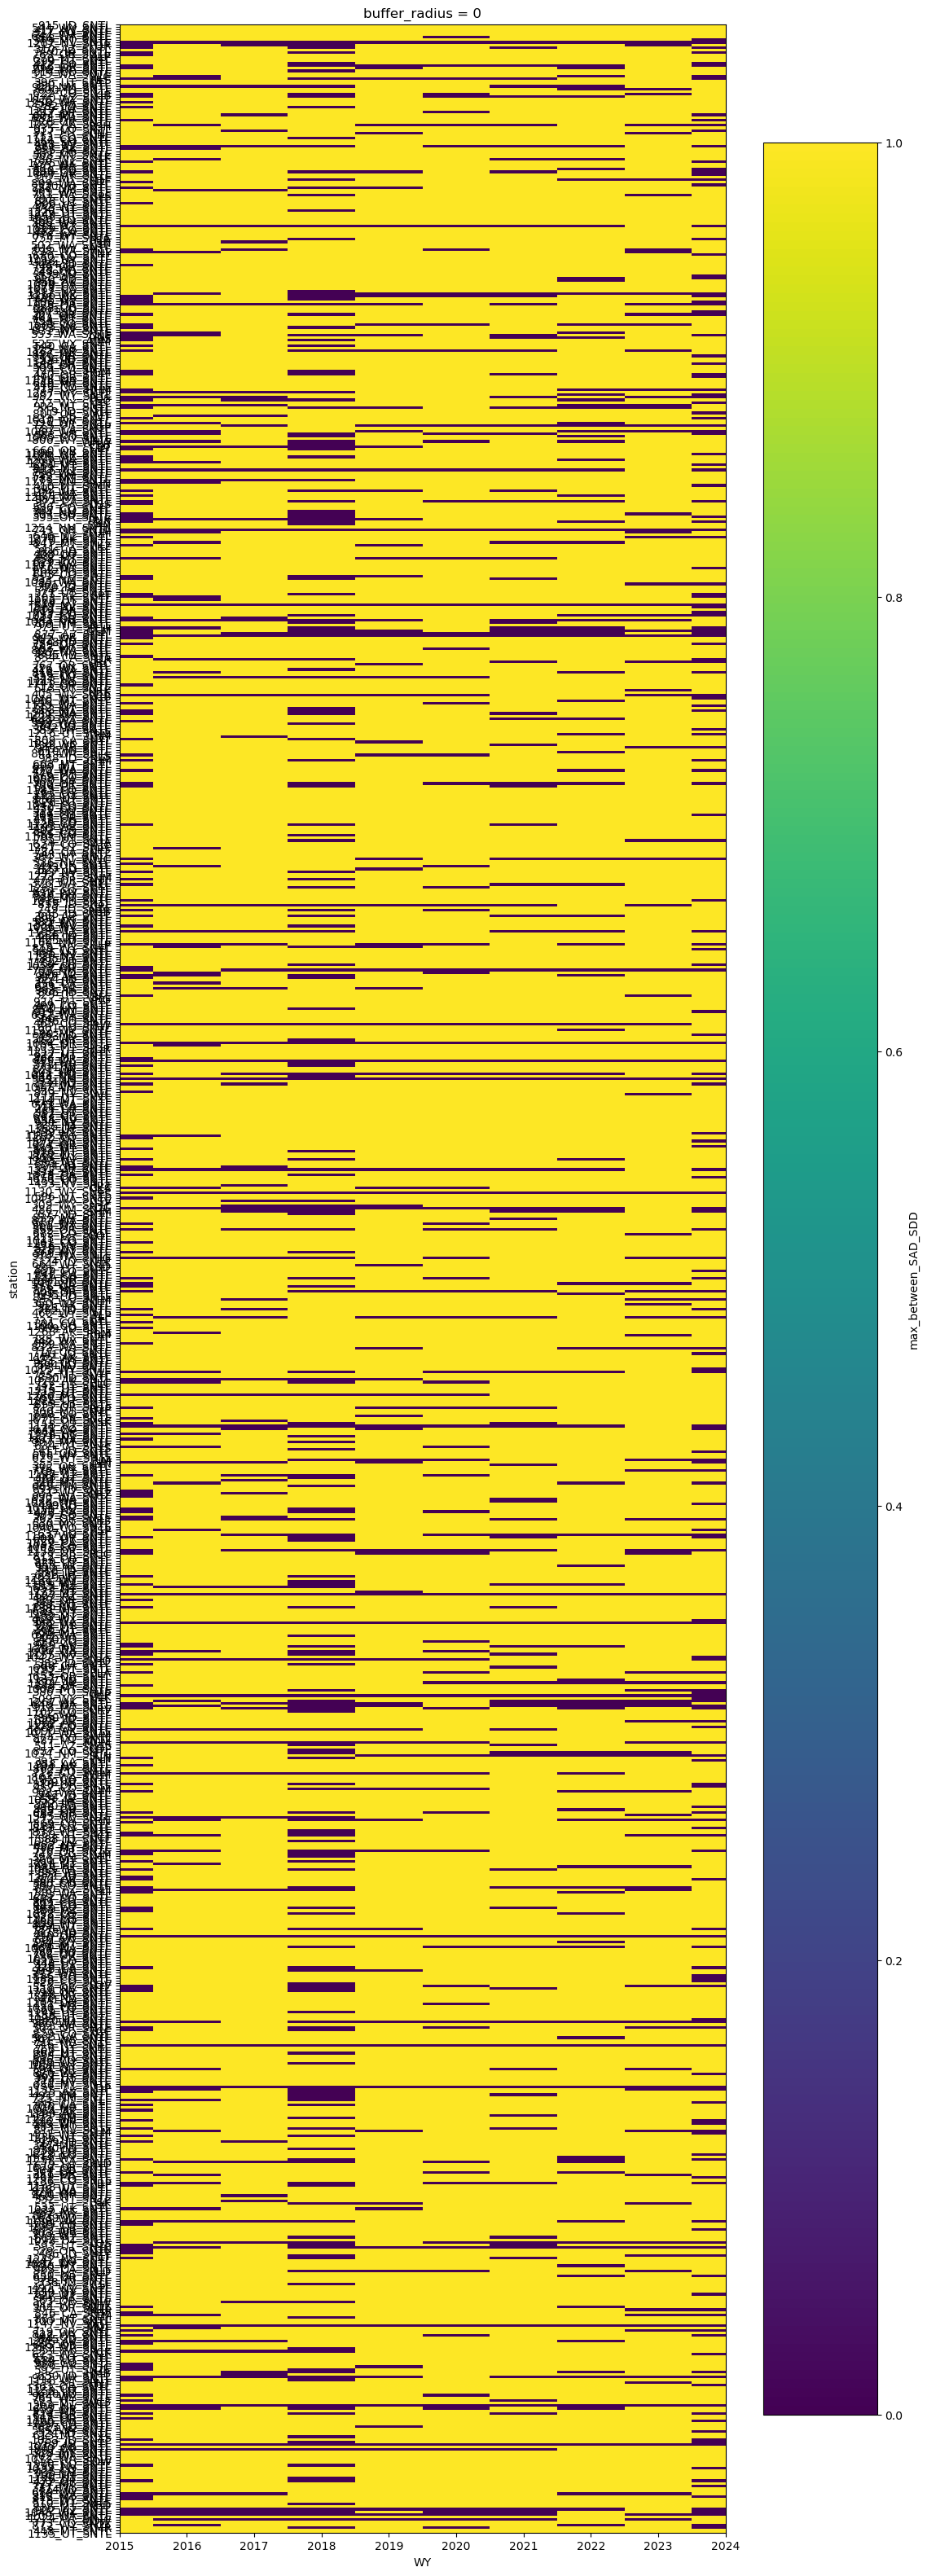

In [6]:
f,ax=plt.subplots(figsize=(12,40))
modis_snow_cover_vs_snotel_max_swe_timing_ds['max_between_SAD_SDD'].sel(buffer_radius=0).plot(ax=ax)

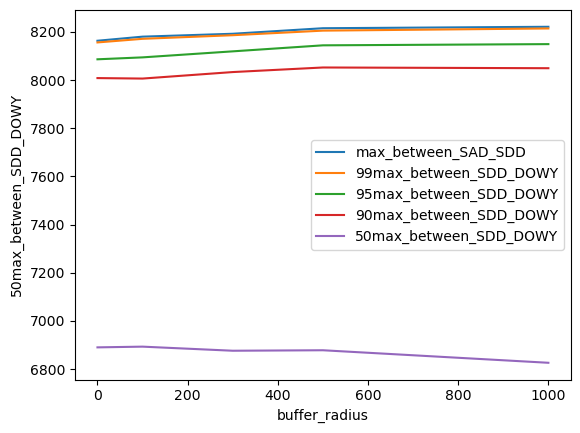

In [7]:
f,ax=plt.subplots()
modis_snow_cover_vs_snotel_max_swe_timing_ds['max_between_SAD_SDD'].sum(dim=['WY','station']).plot(ax=ax, label='max_between_SAD_SDD')
modis_snow_cover_vs_snotel_max_swe_timing_ds['99max_between_SDD_DOWY'].sum(dim=['WY','station']).plot(ax=ax, label='99max_between_SDD_DOWY')
modis_snow_cover_vs_snotel_max_swe_timing_ds['95max_between_SDD_DOWY'].sum(dim=['WY','station']).plot(ax=ax, label='95max_between_SDD_DOWY')
modis_snow_cover_vs_snotel_max_swe_timing_ds['90max_between_SDD_DOWY'].sum(dim=['WY','station']).plot(ax=ax, label='90max_between_SDD_DOWY')
modis_snow_cover_vs_snotel_max_swe_timing_ds['50max_between_SDD_DOWY'].sum(dim=['WY','station']).plot(ax=ax, label='50max_between_SDD_DOWY')
ax.legend()
# looks like higher buffer radius is better. what about nearest vs bilinear resampling?
# for bilinear resampling, valid SWE max between SAD and SDD: array([8163, 8180, 8192, 8215, 8221])

In [8]:
modis_snow_cover_vs_snotel_max_swe_timing_ds['max_SWE_timing_minus_SDD_DOWY'] = modis_snow_cover_vs_snotel_max_swe_timing_ds['station_max_SWE_timing'] - modis_snow_cover_vs_snotel_max_swe_timing_ds['SDD_DOWY']
modis_snow_cover_vs_snotel_max_swe_timing_ds['99max_SWE_timing_minus_SDD_DOWY'] = modis_snow_cover_vs_snotel_max_swe_timing_ds['station_max_SWE_99pct_timing'] - modis_snow_cover_vs_snotel_max_swe_timing_ds['SDD_DOWY']
modis_snow_cover_vs_snotel_max_swe_timing_ds['95max_SWE_timing_minus_SDD_DOWY'] = modis_snow_cover_vs_snotel_max_swe_timing_ds['station_max_SWE_95pct_timing'] - modis_snow_cover_vs_snotel_max_swe_timing_ds['SDD_DOWY']
modis_snow_cover_vs_snotel_max_swe_timing_ds['90max_SWE_timing_minus_SDD_DOWY'] = modis_snow_cover_vs_snotel_max_swe_timing_ds['station_max_SWE_90pct_timing'] - modis_snow_cover_vs_snotel_max_swe_timing_ds['SDD_DOWY']
modis_snow_cover_vs_snotel_max_swe_timing_ds['50max_SWE_timing_minus_SDD_DOWY'] = modis_snow_cover_vs_snotel_max_swe_timing_ds['station_max_SWE_50pct_timing'] - modis_snow_cover_vs_snotel_max_swe_timing_ds['SDD_DOWY']
modis_snow_cover_vs_snotel_max_swe_timing_ds

<xarray.Dataset> Size: 5MB
Dimensions:                          (station: 969, WY: 10, buffer_radius: 5)
Coordinates: (12/14)
    HUC                              (station) <U12 47kB dask.array<chunksize=(969,), meta=np.ndarray>
  * WY                               (WY) int64 80B 2015 2016 2017 ... 2023 2024
    beginDate                        (station) datetime64[ns] 8kB dask.array<chunksize=(969,), meta=np.ndarray>
  * buffer_radius                    (buffer_radius) int64 40B 0 100 ... 1000
    csvData                          (station) bool 969B dask.array<chunksize=(969,), meta=np.ndarray>
    elevation_m                      (station) float64 8kB dask.array<chunksize=(969,), meta=np.ndarray>
    ...                               ...
    longitude                        (station) float64 8kB dask.array<chunksize=(969,), meta=np.ndarray>
    mgrs                             (station) <U5 19kB dask.array<chunksize=(969,), meta=np.ndarray>
    name                             (station) <U24 93kB dask.array<chunksize=(969,), meta=np.ndarray>
    network                          (station) <U6 23kB dask.array<chunksize=(969,), meta=np.ndarray>
    state                            (station) <U12 47kB dask.array<chunksize=(969,), meta=np.ndarray>
  * station                          (station) <U12 47kB '1135_UT_SNTL' ... '...
Data variables: (12/20)
    SAD_DOWY                         (station, WY, buffer_radius) float64 388kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>
    SDD_DOWY                         (station, WY, buffer_radius) float64 388kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>
    fcf                              (station, WY, buffer_radius) float64 388kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>
    max_consec_snow_days             (station, WY, buffer_radius) float64 388kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>
    station_max_SWE_50pct_timing     (station, WY) float64 78kB dask.array<chunksize=(969, 10), meta=np.ndarray>
    station_max_SWE_90pct_timing     (station, WY) float64 78kB dask.array<chunksize=(969, 10), meta=np.ndarray>
    ...                               ...
    50max_between_SDD_DOWY           (station, WY, buffer_radius) bool 48kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>
    max_SWE_timing_minus_SDD_DOWY    (station, WY, buffer_radius) float64 388kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>
    99max_SWE_timing_minus_SDD_DOWY  (station, WY, buffer_radius) float64 388kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>
    95max_SWE_timing_minus_SDD_DOWY  (station, WY, buffer_radius) float64 388kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>
    90max_SWE_timing_minus_SDD_DOWY  (station, WY, buffer_radius) float64 388kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>
    50max_SWE_timing_minus_SDD_DOWY  (station, WY, buffer_radius) float64 388kB dask.array<chunksize=(485, 10, 5), meta=np.ndarray>

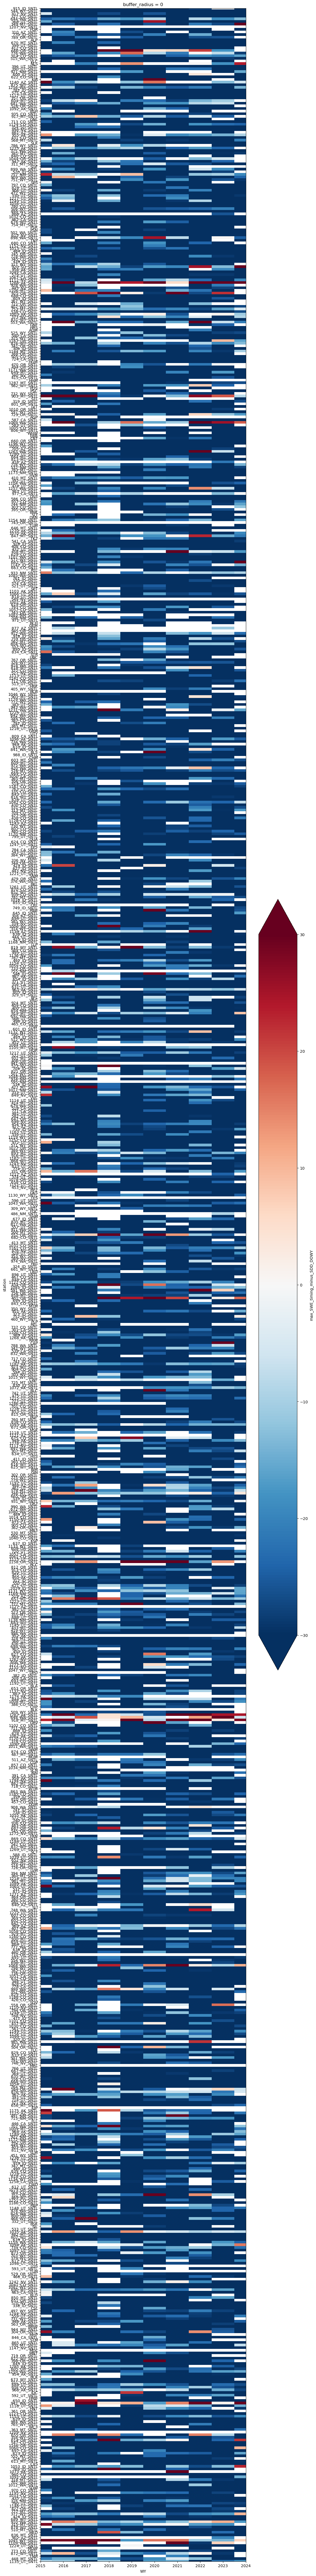

In [9]:
f,ax=plt.subplots(figsize=(12,120))
modis_snow_cover_vs_snotel_max_swe_timing_ds['max_SWE_timing_minus_SDD_DOWY'].sel(buffer_radius=0).plot(ax=ax,vmin=-30,vmax=30,cmap='RdBu_r')

(array([  3.,   1.,   2.,   4.,   3.,   3.,   1.,   5.,  10.,  15.,  38.,
         37.,  43.,  81.,  93., 173., 221., 289., 385., 440., 636., 760.,
        862., 805., 882., 738., 619., 428., 323., 192., 100.,  54.,  36.,
         35.,  29.,  17.,  18.,  13.,  20.,  12.,  11.,   7.,   4.,   1.,
          0.,   2.,   0.,   1.,   1.,   1.]),
 array([-133.        , -128.62931549, -124.25863098, -119.88794647,
        -115.51726196, -111.14657745, -106.77589294, -102.40520844,
         -98.03452393,  -93.66383942,  -89.29315491,  -84.9224704 ,
         -80.55178589,  -76.18110138,  -71.81041687,  -67.43973236,
         -63.06904785,  -58.69836334,  -54.32767883,  -49.95699432,
         -45.58630981,  -41.21562531,  -36.8449408 ,  -32.47425629,
         -28.10357178,  -23.73288727,  -19.36220276,  -14.99151825,
         -10.62083374,   -6.25014923,   -1.87946472,    2.49121979,
           6.8619043 ,   11.23258881,   15.60327332,   19.97395782,
          24.34464233,   28.71532684,   33.086

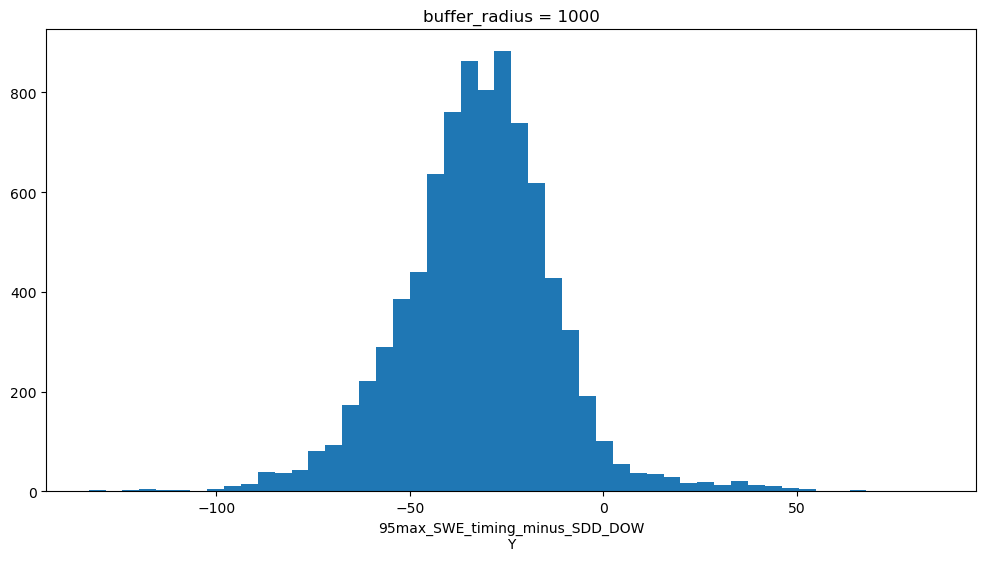

In [10]:
f,ax=plt.subplots(figsize=(12, 6))
modis_snow_cover_vs_snotel_max_swe_timing_ds['95max_SWE_timing_minus_SDD_DOWY'].sel(buffer_radius=1000).plot.hist(bins=50, ax=ax)

## check out some sites with disagreement

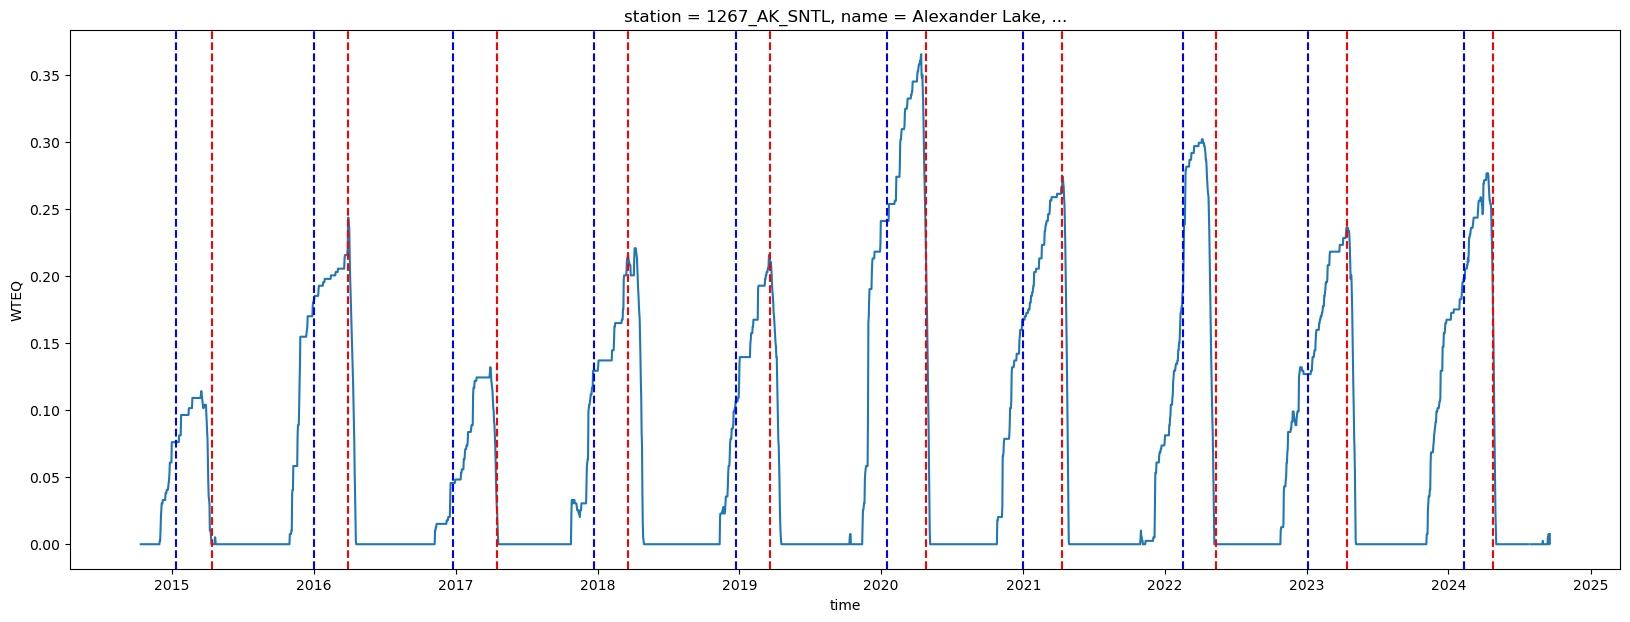

In [34]:
station_code = '903_MT_SNTL'
station_code = '1045_WY_SNTL'
station_code = '648_WA_SNTL'
station_code = '1267_AK_SNTL'


buffer_radius = 1000

f,ax=plt.subplots(figsize=(20,7))

single_station_modis_snow_cover_vs_snotel_max_swe_timing_ds = modis_snow_cover_vs_snotel_max_swe_timing_ds.sel(station=station_code,buffer_radius=buffer_radius).compute()

SAD_DOWY = single_station_modis_snow_cover_vs_snotel_max_swe_timing_ds['SAD_DOWY']
SDD_DOWY = single_station_modis_snow_cover_vs_snotel_max_swe_timing_ds['SDD_DOWY']

stations_WUS_da.sel(station=station_code).plot(ax=ax)

for WY in SAD_DOWY.WY.values:
    SAD_DOWY = pd.to_datetime(f'{WY-1}-10-01') + pd.to_timedelta(single_station_modis_snow_cover_vs_snotel_max_swe_timing_ds['SAD_DOWY'].sel(WY=WY).values, unit='D')
    SDD_DOWY = pd.to_datetime(f'{WY-1}-10-01') + pd.to_timedelta(single_station_modis_snow_cover_vs_snotel_max_swe_timing_ds['SDD_DOWY'].sel(WY=WY).values, unit='D')
    ax.axvline(SAD_DOWY, color='blue', linestyle='--')
    ax.axvline(SDD_DOWY, color='red', linestyle='--')



## code graveyard

In [ ]:
# stations_WUS_da = stations_WUS_da.where(stations_WUS_da>=0)

# abs_diffs = np.abs(stations_WUS_da.diff(dim='time'))
# abs_diffs_forward = abs_diffs.shift(time=1)
# abs_diffs_backward = abs_diffs.shift(time=-1)
# jump_mask = (abs_diffs_forward < 0.2) & (abs_diffs_backward < 0.2)
# stations_WUS_da = stations_WUS_da.where(jump_mask)

# # plot the timeseries for the station with the maximum WTEQ value
# max_station = stations_WUS_da.isel(stations_WUS_da.argmax(dim=['station','time']))
# max_station

# f,ax = plt.subplots(figsize=(20, 5))
# #stations_WUS_da.sel(station='651_OR_SNTL').plot.scatter(ax=ax)
# stations_WUS_da.sel(station='LVT').plot.scatter(ax=ax)

# #ax.set_xlim(pd.Timestamp('2023-10-01'), pd.Timestamp('2024-09-30'))
# # 
# # stations_WUS_da.to_dataframe().describe()['WTEQ']

# # I want to know how many observations are in the dataset at every 0.1 meter interval. So how myna values are 0-0.1, 0.1-0.2, 0.2-0.3, etc.
# # Create bins for 0.1 meter intervals
# bins = np.arange(-0.4, 20.1, 0.1)

# # Use np.histogram to count the number of observations in each bin
# hist, bin_edges = np.histogram(stations_WUS_da.values.flatten(), bins=bins)

# # Create a a pandas DataFrame to hold the histogram data
# hist_df = pd.DataFrame({
#     'bin_start': bin_edges[:-1],
#     'bin_end': bin_edges[1:],
#     'count': hist
# })

# hist_df

# # now plot the histogram, make it log scale on the y-axis
# f,ax=plt.subplots(figsize=(12, 6))
# ax.bar(hist_df['bin_start'], hist_df['count'], width=0.1, align='edge', edgecolor='black')
# ax.set_yscale('log')

